# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-gxs7iaj6
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-gxs7iaj6
  Resolved https://github.com/albumentations-team/albumentations to commit 51e8db5cfae9c3915275494f1e681af2f58ef8c7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


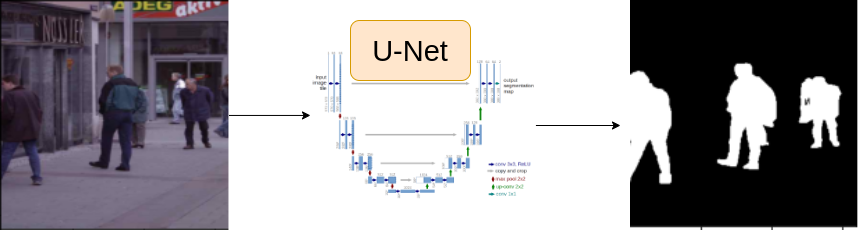

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[0]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

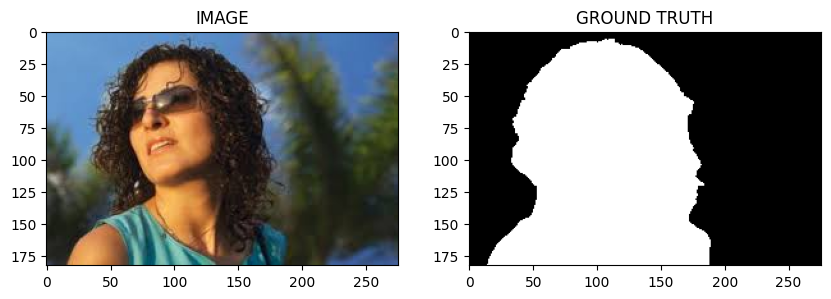

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A
from torchvision import transforms

In [ ]:
def get_train_augs():
    return transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
    ])

def get_valid_augs():
    return transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    ])

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

In [ ]:
class SegmentationDataset(Dataset):

    def __init__(self, df, augmentations):

        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        row = self.df.iloc[idx]

        image_path = row.images
        mask_path = row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  #(h, w, c)

        if self.augmentations:
            image = self.augmentations(image)
            mask = self.augmentations(mask)

            # Convert back to numpy arrays after augmentation
            image = np.array(image)
            mask = np.array(mask)[:, :, np.newaxis]

        #(h, w, c) -> (c, h, w)

        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)

        return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


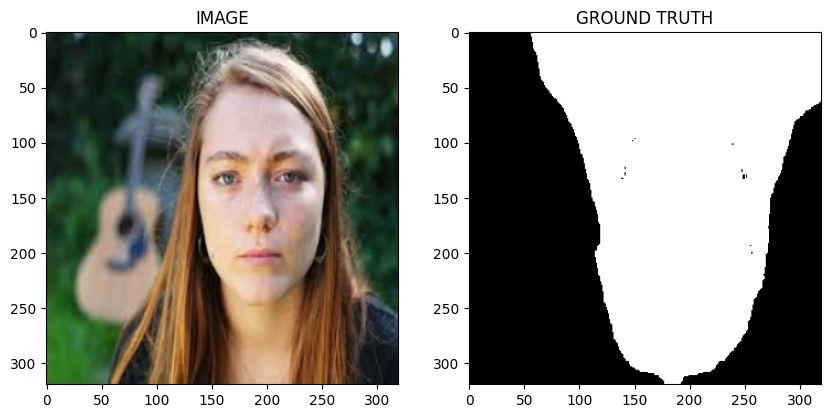

In [ ]:
idx = 0

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [ ]:
print(f"Total number of batches in trainloader : {len(trainloader)}")
print(f"Total number of batches in validloader : {len(validloader)}")

Total number of batches in trainloader : 15
Total number of batches in validloader : 4


In [ ]:
for image, mask in trainloader:
    break

print(f"image shape : {image.shape}")
print(f"mask shape : {mask.shape}")

image shape : torch.Size([16, 3, 320, 320])
mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):

    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.arc = smp.Unet(
            encoder_name = ENCODER,
            encoder_weights = WEIGHTS,
            in_channels = 3,
            classes = 1,
            activation = None
        )

    def forward(self, images, masks = None):

        pred_masks = self.arc(images)

        if masks != None:
            loss1 = DiceLoss(mode='binary')(pred_masks, masks)
            loss2 = nn.BCEWithLogitsLoss()(pred_masks, masks)
            return pred_masks, loss1 + loss2

        return pred_masks

In [ ]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 73.1MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoi

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(data_loader, model, optimizer):

    model.train()
    total_loss = 0.0

    for images, masks in tqdm(data_loader):

        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [ ]:
def eval_fn(data_loader, model, optimizer):

    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for images, masks in tqdm(data_loader):

            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)

            total_loss += loss.item()

        return total_loss / len(data_loader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = eval_fn(validloader, model, optimizer)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print("SAVED MODEL")
        best_valid_loss = valid_loss

    print(f"Epoch : {i+1} Train Loss : {train_loss} Valid Loss : {valid_loss}")

100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


SAVED MODEL
Epoch : 1 Train Loss : 0.7619350353876749 Valid Loss : 0.6591918915510178


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


SAVED MODEL
Epoch : 2 Train Loss : 0.8135021964708964 Valid Loss : 0.5782450214028358


100%|██████████| 4/4 [00:00<00:00,  4.38it/s]


Epoch : 3 Train Loss : 0.7749329527219136 Valid Loss : 0.7553744614124298


100%|██████████| 4/4 [00:00<00:00,  4.49it/s]


Epoch : 4 Train Loss : 0.7947308580080669 Valid Loss : 0.7546860575675964


100%|██████████| 4/4 [00:00<00:00,  4.51it/s]


Epoch : 5 Train Loss : 0.7692891637484233 Valid Loss : 0.6424144506454468


100%|██████████| 4/4 [00:00<00:00,  4.52it/s]


Epoch : 6 Train Loss : 0.752631688117981 Valid Loss : 0.5929476171731949


100%|██████████| 4/4 [00:00<00:00,  4.28it/s]


Epoch : 7 Train Loss : 0.7596130609512329 Valid Loss : 0.5797212868928909


100%|██████████| 4/4 [00:00<00:00,  4.41it/s]


SAVED MODEL
Epoch : 8 Train Loss : 0.7118303934733073 Valid Loss : 0.5012171342968941


100%|██████████| 4/4 [00:00<00:00,  4.44it/s]


Epoch : 9 Train Loss : 0.7322948098182678 Valid Loss : 0.6770516633987427


100%|██████████| 4/4 [00:00<00:00,  4.37it/s]


Epoch : 10 Train Loss : 0.7141975839932759 Valid Loss : 0.5982522815465927


100%|██████████| 4/4 [00:00<00:00,  4.55it/s]


Epoch : 11 Train Loss : 0.6896043578783672 Valid Loss : 0.5628564208745956


100%|██████████| 4/4 [00:00<00:00,  4.43it/s]


Epoch : 12 Train Loss : 0.7152241508165995 Valid Loss : 0.7316828072071075


100%|██████████| 4/4 [00:00<00:00,  4.63it/s]


Epoch : 13 Train Loss : 0.6818553249041239 Valid Loss : 0.5740613341331482


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


Epoch : 14 Train Loss : 0.6881220062573751 Valid Loss : 0.5702982246875763


100%|██████████| 4/4 [00:00<00:00,  4.53it/s]


Epoch : 15 Train Loss : 0.6726545532544453 Valid Loss : 0.5595794171094894


100%|██████████| 4/4 [00:00<00:00,  4.62it/s]


Epoch : 16 Train Loss : 0.6925629695256551 Valid Loss : 0.7199749797582626


100%|██████████| 4/4 [00:01<00:00,  3.87it/s]


Epoch : 17 Train Loss : 0.7083762288093567 Valid Loss : 0.5410893112421036


100%|██████████| 4/4 [00:00<00:00,  4.53it/s]


Epoch : 18 Train Loss : 0.6900909622510274 Valid Loss : 0.6338071376085281


100%|██████████| 4/4 [00:00<00:00,  4.57it/s]


Epoch : 19 Train Loss : 0.6961167136828105 Valid Loss : 0.5317050591111183


100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


Epoch : 20 Train Loss : 0.6687763492266338 Valid Loss : 0.5858357548713684


100%|██████████| 4/4 [00:00<00:00,  4.51it/s]


Epoch : 21 Train Loss : 0.6839867949485778 Valid Loss : 0.5850185453891754


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch : 22 Train Loss : 0.6682270169258118 Valid Loss : 0.5903382748365402


100%|██████████| 4/4 [00:01<00:00,  3.59it/s]


Epoch : 23 Train Loss : 0.6743213017781575 Valid Loss : 0.562247633934021


100%|██████████| 4/4 [00:00<00:00,  4.62it/s]


Epoch : 24 Train Loss : 0.6675756971041361 Valid Loss : 0.5690643340349197


100%|██████████| 4/4 [00:00<00:00,  4.51it/s]

Epoch : 25 Train Loss : 0.6707595547040304 Valid Loss : 0.501864418387413


# Task 9 : Inference

In [ ]:
idx = 20

model.load_state_dict(torch.load('best_model.pth'))

image, mask = validset[idx]
logits_mask = model(image.to(DEVICE).unsqueeze(0))   #(C, H, W) --> (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0
pred_mask = pred_mask.detach().cpu().squeeze(0)

<ipython-input-143-52c48060bbba>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


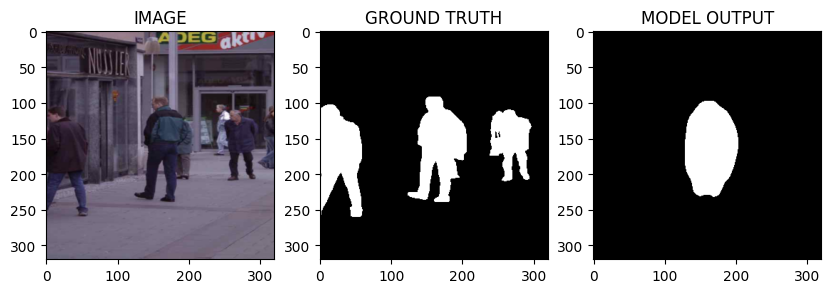

In [ ]:
helper.show_image(image, mask, pred_mask)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya